# Simple word-counting and TF-IDF semantics

In [2]:
# Load sys to read files
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

import nltk
from nltk.corpus import reuters
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('reuters')

In [3]:
# List downloaded files

# os.listdir('Data/reuters21578/')

After reading the README text, I know that the collection I am interested in is in the 22 sgm files. 
To access these files, I will use `open as infile`. 

There are 6 files describing the categories used to index the data as well.

Opening just one file as an example:

In [4]:
# Open a first file as an example. Used 'r' because it is text mode parsing (read only).
with open('../Data/reuters21578/reut2-008.sgm', 'r', encoding = 'utf-8', errors = 'ignore') as infile:
        data = infile.read()

# To print as a sanity check, uncomment.
#print(data)

Despite the difficult format presentation, the corpus is there. 

I will open all the files in the directory and assemble them in an array called data.

In [5]:
data = []

for i in range(22):
    # Open all filenames. Pad {0} to 3 digits with str methods. 
    # Use range from 0 to 22.
    filename = '../Data/reuters21578/reut2-{0}.sgm'.format(str(i).zfill(3))
    
    # Encoding with most common scheme.
    with open(filename, 'r', encoding = 'utf-8', errors = 'ignore') as infile:
        data.append(infile.read())
        
# Print first 100 characters of the first article
data[0][:600]

'<!DOCTYPE lewis SYSTEM "lewis.dtd">\n<REUTERS TOPICS="YES" LEWISSPLIT="TRAIN" CGISPLIT="TRAINING-SET" OLDID="5544" NEWID="1">\n<DATE>26-FEB-1987 15:01:01.79</DATE>\n<TOPICS><D>cocoa</D></TOPICS>\n<PLACES><D>el-salvador</D><D>usa</D><D>uruguay</D></PLACES>\n<PEOPLE></PEOPLE>\n<ORGS></ORGS>\n<EXCHANGES></EXCHANGES>\n<COMPANIES></COMPANIES>\n<UNKNOWN> \n&#5;&#5;&#5;C T\n&#22;&#22;&#1;f0704&#31;reute\nu f BC-BAHIA-COCOA-REVIEW   02-26 0105</UNKNOWN>\n<TEXT>&#2;\n<TITLE>BAHIA COCOA REVIEW</TITLE>\n<DATELINE>    SALVADOR, Feb 26 - </DATELINE><BODY>Showers continued throughout the week in\nthe Bahia cocoa zone, alle'

All corpora have been set up in an array of arrays. We can see that the text format seems to have a HTML presentation. In order to give some format, I will use BeautifulSoup package.

As a sanity check, I will see what the NLTK package has for 'Reuters' database. 

In [6]:
# nltk.corpus.reuters.raw()

Looks like it is the same database, however the articles are in different order.

Now, I will use BeautifulSoup to parse the text. BeautifulSoup will allow to remove all the HTML tags. There are several ways to do this. I could run a loop and attach an article between the tags of <Body> to a dataframe. 

In [7]:
from bs4 import BeautifulSoup
example_soup = BeautifulSoup(data[0], 'html.parser')

# print(example_soup.prettify()) # Makes the above easier to read. More as we would see on a describe HTML panel (when scrapping).
# print(example_soup.get_text())  # Removes HTML flags.
# print(example_soup.find_all('body')) # Extracts the text from the HTML tag we choose. This case, the 'Body' tag.

In [8]:
type(example_soup)

bs4.BeautifulSoup

Let's now put all the corpus in the soup. The soup object can just take one index at a time. We need to iterate over our data list.

In [9]:
corpora = []
for text in data:
    # Parse text as html using beautiful soup
    parsed_text = BeautifulSoup(text, 'html.parser')
    table = parsed_text.find_all('body')[0] 
#print(table)

#type(table)

In [10]:
corpora = []
for text in data:
    # Parse text as html using beautiful soup
    parsed_text = BeautifulSoup(text, 'html.parser')
    
    # Extract article between <BODY> and </BODY> and convert to standard text. Add to list of articles
    corpora += [corpora.get_text() for corpora in parsed_text.find_all('body')]

# Print first article as an example
print(corpora[0][:300])

Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will b


In [11]:
# Make Corpora be a DF

df_corpora = pd.DataFrame({'Body': corpora})
df_corpora.head(2)

,Body
0,Showers continued throughout the week in\nthe ...
1,Standard Oil Co and BP North America\nInc said...


## Exploring the Data

Although I have removed some HTML tags, before normalizingthe data, I would still want to remove symbols such as \n or the word Reuter that appears at the end of all articles. This word is not necessary for my analysis. 

Afterwards, I will do a more formal "Normalizing" of the data.

In [12]:
# Option to see the whole column
pd.set_option('display.max_colwidth', 100)

# Removing symbols such as \n, Reuter, and '' that are just showing break lines.
df_corpora = df_corpora.replace('"', '', regex = True)\
                       .replace("\n", ' ', regex = True)\
                       .replace(' Reuter', '', regex = True)

In [13]:
df_corpora.head(1)

,Body
0,"Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since ear..."


In this first part of the Text Analysis, I want to see, before any text normalization, how many words on average an article has. 

In order to count sentences, I will rely that a sentence finishes with a dot (.) and and it is followed by a space. It is important to note that dots (.) could also be a part of a float number. 

In order to count words, I will split the column "Body" of my data frame and count the length of it. 

For characters, I will take into consdieration the length of the "Body" of an article.

In [14]:
df_corpora['Sentences'] = df_corpora['Body'].str.count('\. ')
df_corpora['Total_Words'] = [len(x.split()) for x in df_corpora['Body'].tolist()]
df_corpora['Total_Char'] = [len(x) for x in df_corpora['Body'].tolist()]

In [15]:
pd.set_option('display.max_colwidth', 100)
df_corpora.head(4)

,Body,Sentences,Total_Words,Total_Char
0,"Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since ear...",20,487,2854
1,Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money ma...,3,73,432
2,Texas Commerce Bancshares Inc's Texas Commerce Bank-Houston said it filed an application with th...,2,52,324
3,BankAmerica Corp is not under pressure to act quickly on its proposed equity offering and would ...,17,456,2836


Now, I would want to see some statistics regarding my data frame. For example, I want to know on average how many words/sentences/characters an article has.

In [16]:
summary = df_corpora.describe().transpose()
summary[['count', 'mean', '50%', 'min', 'max']]

,count,mean,50%,min,max
Sentences,19043.0,6.058027,4.0,0.0,67.0
Total_Words,19043.0,135.010923,89.0,2.0,1668.0
Total_Char,19043.0,829.499711,547.0,6.0,13390.0


What I find the most interesting is that on average, an article has only 4 sentences. And there are articles that do not even have a sentence. I would want to explore into this a little bit more. 

In [17]:
df_corpora[df_corpora['Sentences'] == 0].count()

Body           1761
Sentences      1761
Total_Words    1761
Total_Char     1761
dtype: int64

1701 articles have 0 sentences. I will look into them and see what kind of articles they could be.

In [18]:
df_corpora[df_corpora['Sentences'] == 0].head(10)

,Body,Sentences,Total_Words,Total_Char
13,Shr one dlr vs 73 cts Net 12.6 mln vs 15.8 mln Revs 337.3 mln vs 315.2 mln Nine mths...,0,39,192
33,Qtly div eights cts vs 7.5 cts prior Pay March 31 Record March 13 ,0,15,76
35,"Shr 45 cts vs 58 cts Net 1.1 mln vs 829,000 Sales 7.9 mln vs 9.4 mln Avg shrs 2,332,...",0,47,249
50,Qtly div 35 cts vs 35 cts prior Payable March 31 Record March nine ,0,15,78
62,"Shr 80 cts vs 72 cts Net 55,513,000 vs 48,741,000 Revs 290.9 mln vs 264.2 mln Year ...",0,39,236
68,Qtly div eights cts vs eight cts prior Pay April one Record March 13 ,0,15,79
79,Qtly div 25 cts vs 25 cts prior Pay April 30 Record April 16 ,0,15,71
80,Qtly div two cts vs 1.7 cts Pay March 26 Record March 12 ,0,14,67
83,Qtly div three cts vs three cts prior Pay March 13 Record February 27 ,0,15,80
89,"Shr profit three cts vs loss three cts Net profit 363,000 vs loss 197,000 Revs 3,761,000...",0,45,268


From the information above, we can see these articles could be talking about dividends or revenues. They are just phrases and most words are in a shortened form.

One way to see what these data is all about would be to go back to the Beautiful soup and allign all data in a data frame, consider titles and article type.

I choose to not remove these articles because although I am currently just exploring the data set, maybe later on, I could use this data to predict what kind of news this article belongs to. 

## Making some plots
I am curious about how the distributions look like, if most articles tend to have more than 10 sentences or if they are usually longer. 

I will plot three histograms to see how Sentences, Words, and Characters manifest their distributions.

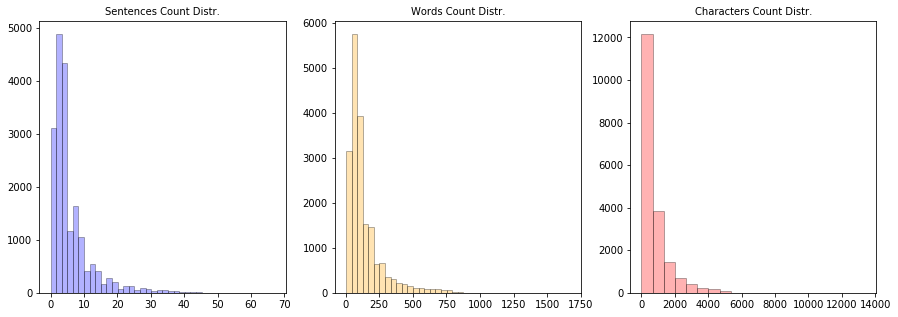

In [19]:
fig, axs = plt.subplots(1, 3, tight_layout = False, figsize = (15,5))

axs[0].hist(df_corpora['Sentences'], color = 'blue', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[0].set_title('Sentences Count Distr.',fontsize='medium')
axs[1].hist(df_corpora['Total_Words'], color = 'orange', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[1].set_title('Words Count Distr.',fontsize='medium')
axs[2].hist(df_corpora['Total_Char'], color = 'red', edgecolor = 'black', alpha = 0.3, bins = int(20))
axs[2].set_title('Characters Count Distr.',fontsize='medium')


plt.show()

Out of about 19000 articles, less than 50% have only 4 sentences/89 words/548 characters. I think this is because about 1800 articles were "stock market" articles and these articles are very short and have just shortened words and values. 

## Tokenizing and Using N-Grams in the Dataframe

In [20]:
from nltk.util import ngrams

df_corpora['tokenized_sents'] = df_corpora.apply(lambda row: nltk.word_tokenize(row['Body']), axis=1)
df_corpora['Bigrams']= df_corpora['tokenized_sents'].apply(lambda row: list(nltk.ngrams(row, 2)))
df_corpora['Bigram_count'] = df_corpora['Bigrams'].str.len()
df_corpora[['Body','tokenized_sents', 'Bigrams', 'Bigram_count']].head(3)

,Body,tokenized_sents,Bigrams,Bigram_count
0,"Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since ear...","[Showers, continued, throughout, the, week, in, the, Bahia, cocoa, zone, ,, alleviating, the, dr...","[(Showers, continued), (continued, throughout), (throughout, the), (the, week), (week, in), (in,...",526
1,Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money ma...,"[Standard, Oil, Co, and, BP, North, America, Inc, said, they, plan, to, form, a, venture, to, ma...","[(Standard, Oil), (Oil, Co), (Co, and), (and, BP), (BP, North), (North, America), (America, Inc)...",78
2,Texas Commerce Bancshares Inc's Texas Commerce Bank-Houston said it filed an application with th...,"[Texas, Commerce, Bancshares, Inc, 's, Texas, Commerce, Bank-Houston, said, it, filed, an, appli...","[(Texas, Commerce), (Commerce, Bancshares), (Bancshares, Inc), (Inc, 's), ('s, Texas), (Texas, C...",54


In [21]:
# Sanity check to make sure bigrams are being counted accordingly
# pd.set_option('display.max_colwidth', -1)
# df_corpora[df_corpora["Bigram_count"] == 10]

## Normalizing the Data

Now, I wonder if I removed stop words, punctuation and changed my vocabulary to a lemmatized one, how would all these features change. I will have for sure less characters and words. But I would also have no sentences. 

Usually, when working with text data, we must normalize by: lowering capital letters, removing punctuation signs and digits and changing vocabulary to their lemmas or stems.

In [22]:
# Remove stopwords, punctuation, digits.
df_corpora['Norm_Body'] = df_corpora['Body'].str.lower()\
                                             .replace('"', '', regex = True)\
                                             .str.replace('[^\w\s]','')\
                                             .replace("\[[0-9]*\]","", regex = True)\
                                             .str.replace('\d+', '')#\
                                            # .apply(lambda x: [item for item in x if item not in stop_words])

In [23]:
# Removing stopwords
stop_words = list(set(stopwords.words('english')))
df_corpora['Norm_Body'] = df_corpora['Norm_Body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [24]:
pd.set_option('display.max_colwidth', 300)
df_corpora[['Body', 'Norm_Body']].head(2)

,Body,Norm_Body
0,"Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao wi...",showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february bags kilos making cumulativ...
1,"Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money market borrowing and investment activities of both companies. BP North America is a subsidiary of British Petroleum Co Plc <BP>, which also owns a 55 pct interest in Standard Oil. The venture wi...",standard oil co bp north america inc said plan form venture manage money market borrowing investment activities companies bp north america subsidiary british petroleum co plc bp also owns pct interest standard oil venture called bpstandard financial trading operated standard oil oversight joint ...


In [25]:
df_corpora['NB_Sentences'] = df_corpora['Norm_Body'].str.count('\. ')
df_corpora['NB_Total_Words'] = [len(x.split()) for x in df_corpora['Norm_Body'].tolist()]
df_corpora['NB_Total_Char'] = [len(x) for x in df_corpora['Norm_Body'].tolist()]

In [26]:
summary = pd.DataFrame(df_corpora.describe().transpose())

summary[['mean', 'min', '50%', 'max']].loc[['Total_Words','NB_Total_Words', 'Total_Char', "NB_Total_Char"]]

,mean,min,50%,max
Total_Words,135.010923,2.0,89.0,1668.0
NB_Total_Words,81.000998,0.0,54.0,819.0
Total_Char,829.499711,6.0,547.0,13390.0
NB_Total_Char,580.564039,0.0,385.0,6350.0


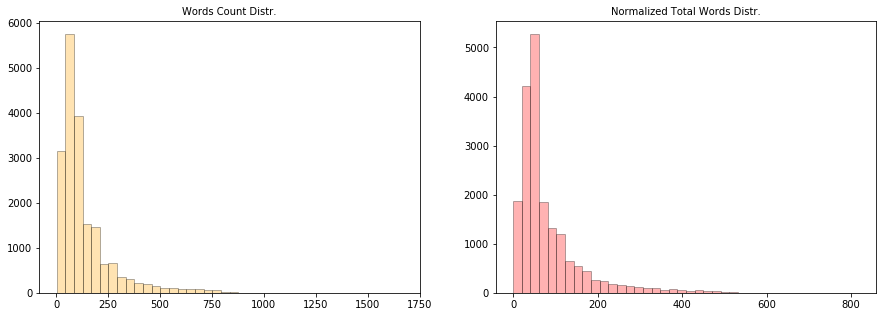

In [27]:
# Plots comparing word count

fig, axs = plt.subplots(1, 2, tight_layout = False, figsize = (15,5))

axs[0].hist(df_corpora['Total_Words'], color = 'orange', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[0].set_title('Words Count Distr.',fontsize='medium')
axs[1].hist(df_corpora['NB_Total_Words'], color = 'red', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[1].set_title('Normalized Total Words Distr.',fontsize='medium')


plt.show()

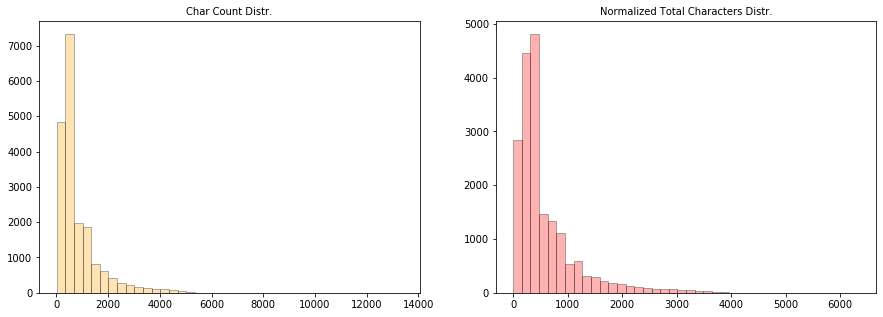

In [28]:
# Plots comparing char count

fig, axs = plt.subplots(1, 2, tight_layout = False, figsize = (15,5))

axs[0].hist(df_corpora['Total_Char'], color = 'orange', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[0].set_title('Char Count Distr.',fontsize='medium')
axs[1].hist(df_corpora['NB_Total_Char'], color = 'red', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[1].set_title('Normalized Total Characters Distr.',fontsize='medium')


plt.show()

In [29]:
df_corpora['norm_tokenized_sents'] = df_corpora.apply(lambda row: nltk.word_tokenize(row['Norm_Body']), axis=1)
df_corpora['Norm_Bigrams']= df_corpora['norm_tokenized_sents'].apply(lambda row: list(nltk.ngrams(row, 2)))
df_corpora[['Norm_Body','norm_tokenized_sents', 'Norm_Bigrams']].head(3)

,Norm_Body,norm_tokenized_sents,Norm_Bigrams
0,showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february bags kilos making cumulativ...,"[showers, continued, throughout, week, bahia, cocoa, zone, alleviating, drought, since, early, january, improving, prospects, coming, temporao, although, normal, humidity, levels, restored, comissaria, smith, said, weekly, review, dry, period, means, temporao, late, year, arrivals, week, ended, ...","[(showers, continued), (continued, throughout), (throughout, week), (week, bahia), (bahia, cocoa), (cocoa, zone), (zone, alleviating), (alleviating, drought), (drought, since), (since, early), (early, january), (january, improving), (improving, prospects), (prospects, coming), (coming, temporao)..."
1,standard oil co bp north america inc said plan form venture manage money market borrowing investment activities companies bp north america subsidiary british petroleum co plc bp also owns pct interest standard oil venture called bpstandard financial trading operated standard oil oversight joint ...,"[standard, oil, co, bp, north, america, inc, said, plan, form, venture, manage, money, market, borrowing, investment, activities, companies, bp, north, america, subsidiary, british, petroleum, co, plc, bp, also, owns, pct, interest, standard, oil, venture, called, bpstandard, financial, trading,...","[(standard, oil), (oil, co), (co, bp), (bp, north), (north, america), (america, inc), (inc, said), (said, plan), (plan, form), (form, venture), (venture, manage), (manage, money), (money, market), (market, borrowing), (borrowing, investment), (investment, activities), (activities, companies), (c..."
2,texas commerce bancshares incs texas commerce bankhouston said filed application comptroller currency effort create largest banking network harris county bank said network would link banks billion dlrs assets billion dlrs deposits,"[texas, commerce, bancshares, incs, texas, commerce, bankhouston, said, filed, application, comptroller, currency, effort, create, largest, banking, network, harris, county, bank, said, network, would, link, banks, billion, dlrs, assets, billion, dlrs, deposits]","[(texas, commerce), (commerce, bancshares), (bancshares, incs), (incs, texas), (texas, commerce), (commerce, bankhouston), (bankhouston, said), (said, filed), (filed, application), (application, comptroller), (comptroller, currency), (currency, effort), (effort, create), (create, largest), (larg..."


In [30]:
df_corpora['Norm_Bigram_count'] = df_corpora['Norm_Bigrams'].str.len()
bigrams_df = df_corpora[['Norm_Bigram_count', 'Bigram_count']].reset_index(drop=True)
bigrams_df

,Norm_Bigram_count,Bigram_count
0,270,526
1,44,78
2,30,54
3,262,510
4,80,156
...,...,...
19038,40,76
19039,191,372
19040,51,88
19041,114,211


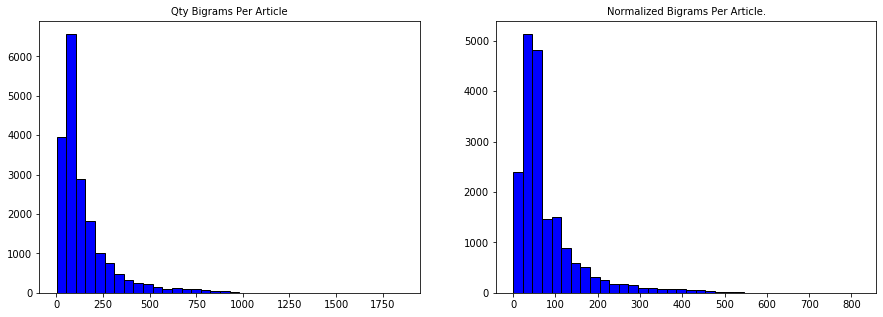

In [31]:
# Plots comparing bigrams

fig, axs = plt.subplots(1, 2, tight_layout = False, figsize = (15,5))

axs[0].hist(bigrams_df['Bigram_count'], color = 'blue', edgecolor = 'black', bins = int(180/5))
axs[0].set_title('Qty Bigrams Per Article', fontsize = 'medium')
axs[1].hist(bigrams_df['Norm_Bigram_count'], color = 'blue', edgecolor = 'black', bins = int(180/5))
axs[1].set_title('Normalized Bigrams Per Article.',fontsize='medium')


plt.show()

In [32]:
# Create a bigrams list to count frequencies

bigrams_list = df_corpora['Norm_Bigrams'].tolist()

In [33]:
flat_bigrams_list = []
for sublist in bigrams_list:
    for item in sublist:
        flat_bigrams_list.append(item)

        
# Dictionary to count frequencies
bigram_freq = {}
for raw_bigram in flat_bigrams_list:
    if raw_bigram not in bigram_freq:
        bigram_freq[raw_bigram] = 1 
    bigram_freq[raw_bigram] += 1
    
#bigram_freq

In [34]:
# If we want to see all the bigrams sorted, uncomment below.

#{k: v for k, v in sorted(bigram_freq.items(), key=lambda item: item[1], reverse = True)}

In [35]:
# To just see the 20 highest values. 
from collections import Counter 
  
k = Counter(bigram_freq) 
  
# Finding 3 highest values 
most_common_bigrams = k.most_common(20)  
  
print("Most repeated bigrams:") 
print("Keys: Values") 
  
for i in most_common_bigrams: 
    print(i[0]," :",i[1]," ")

Most repeated bigrams:
Keys: Values
('mln', 'dlrs')  : 7968  
('mln', 'vs')  : 4009  
('vs', 'mln')  : 3998  
('billion', 'dlrs')  : 3587  
('cts', 'vs')  : 3447  
('company', 'said')  : 3203  
('inc', 'said')  : 2478  
('cts', 'net')  : 2261  
('last', 'year')  : 2034  
('vs', 'cts')  : 2017  
('corp', 'said')  : 1952  
('vs', 'loss')  : 1780  
('net', 'vs')  : 1637  
('revs', 'mln')  : 1590  
('shr', 'cts')  : 1459  
('per', 'share')  : 1410  
('sources', 'said')  : 1285  
('also', 'said')  : 1229  
('dlrs', 'vs')  : 1195  
('mln', 'dlr')  : 1133  


It is visible that the most common words are still financial related and most of them are shortened. 

I am still missing one point of normalization at this point. Lemmatizing or Stemming. Both of these terms refer to getting the root of the word and counting all similar words the same way. For example, continued and continue share a very close meaning. 

## Lemmatization and Stemming

In [36]:
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [37]:
df_corpora['Lemmatize'] = df_corpora['Norm_Body'].apply(lambda x: lemmatize_sentence(x))
#print(df_corpora['Lemmatize'].head())

In [38]:
df_corpora['norm_lemm_token_sents'] = df_corpora.apply(lambda row: nltk.word_tokenize(row['Lemmatize']), axis=1)
df_corpora['Norm_Lemm_Bigrams']= df_corpora['norm_lemm_token_sents'].apply(lambda row: list(nltk.ngrams(row, 2)))
df_corpora[['Norm_Body','Lemmatize', 'Norm_Bigrams', 'Norm_Lemm_Bigrams']].head(3)

,Norm_Body,Lemmatize,Norm_Bigrams,Norm_Lemm_Bigrams
0,showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february bags kilos making cumulativ...,shower continue throughout week bahia cocoa zone alleviate drought since early january improve prospect come temporao although normal humidity level restore comissaria smith say weekly review dry period mean temporao late year arrival week end february bag kilos make cumulative total season mln ...,"[(showers, continued), (continued, throughout), (throughout, week), (week, bahia), (bahia, cocoa), (cocoa, zone), (zone, alleviating), (alleviating, drought), (drought, since), (since, early), (early, january), (january, improving), (improving, prospects), (prospects, coming), (coming, temporao)...","[(shower, continue), (continue, throughout), (throughout, week), (week, bahia), (bahia, cocoa), (cocoa, zone), (zone, alleviate), (alleviate, drought), (drought, since), (since, early), (early, january), (january, improve), (improve, prospect), (prospect, come), (come, temporao), (temporao, alth..."
1,standard oil co bp north america inc said plan form venture manage money market borrowing investment activities companies bp north america subsidiary british petroleum co plc bp also owns pct interest standard oil venture called bpstandard financial trading operated standard oil oversight joint ...,standard oil co bp north america inc say plan form venture manage money market borrow investment activity company bp north america subsidiary british petroleum co plc bp also own pct interest standard oil venture call bpstandard financial trading operate standard oil oversight joint management c...,"[(standard, oil), (oil, co), (co, bp), (bp, north), (north, america), (america, inc), (inc, said), (said, plan), (plan, form), (form, venture), (venture, manage), (manage, money), (money, market), (market, borrowing), (borrowing, investment), (investment, activities), (activities, companies), (c...","[(standard, oil), (oil, co), (co, bp), (bp, north), (north, america), (america, inc), (inc, say), (say, plan), (plan, form), (form, venture), (venture, manage), (manage, money), (money, market), (market, borrow), (borrow, investment), (investment, activity), (activity, company), (company, bp), (..."
2,texas commerce bancshares incs texas commerce bankhouston said filed application comptroller currency effort create largest banking network harris county bank said network would link banks billion dlrs assets billion dlrs deposits,texas commerce bancshares incs texas commerce bankhouston say file application comptroller currency effort create large banking network harris county bank say network would link bank billion dlrs asset billion dlrs deposit,"[(texas, commerce), (commerce, bancshares), (bancshares, incs), (incs, texas), (texas, commerce), (commerce, bankhouston), (bankhouston, said), (said, filed), (filed, application), (application, comptroller), (comptroller, currency), (currency, effort), (effort, create), (create, largest), (larg...","[(texas, commerce), (commerce, bancshares), (bancshares, incs), (incs, texas), (texas, commerce), (commerce, bankhouston), (bankhouston, say), (say, file), (file, application), (application, comptroller), (comptroller, currency), (currency, effort), (effort, create), (create, large), (large, ban..."


In [39]:
# Create a bigrams list to count frequencies

lemm_bigrams_list = df_corpora['Norm_Lemm_Bigrams'].tolist()


flat_lemm_bigrams_list = []
for sublist in lemm_bigrams_list:
    for item in sublist:
        flat_lemm_bigrams_list.append(item)
        
        
# Dictionary for counting freq
lemm_bigram_freq = {}
for raw_bigram in flat_lemm_bigrams_list:
    if raw_bigram not in lemm_bigram_freq:
        lemm_bigram_freq[raw_bigram] = 0 
    lemm_bigram_freq[raw_bigram] += 1

lk = Counter(lemm_bigram_freq) 
  
# Finding 3 highest values 
most_common_lemm_bigrams = lk.most_common(20)  
  
print("Most repeated bigrams:") 
print("Keys: Values") 
  
for i in most_common_lemm_bigrams: 
    print(i[0]," :",i[1]," ")

Most repeated bigrams:
Keys: Values
('mln', 'dlrs')  : 7968  
('billion', 'dlrs')  : 3590  
('ct', 'vs')  : 3385  
('company', 'say')  : 3348  
('v', 'mln')  : 3074  
('mln', 'v')  : 2972  
('inc', 'say')  : 2481  
('last', 'year')  : 2401  
('ct', 'net')  : 2310  
('corp', 'say')  : 1954  
('vs', 'ct')  : 1943  
('rev', 'mln')  : 1656  
('net', 'v')  : 1547  
('official', 'say')  : 1530  
('shr', 'ct')  : 1454  
('source', 'say')  : 1454  
('per', 'share')  : 1412  
('also', 'say')  : 1232  
('new', 'york')  : 1149  
('mln', 'dlr')  : 1133  


In [40]:
# To compare prev lemmatizing
for i in most_common_bigrams: 
    print(i[0]," :",i[1]," ")

('mln', 'dlrs')  : 7968  
('mln', 'vs')  : 4009  
('vs', 'mln')  : 3998  
('billion', 'dlrs')  : 3587  
('cts', 'vs')  : 3447  
('company', 'said')  : 3203  
('inc', 'said')  : 2478  
('cts', 'net')  : 2261  
('last', 'year')  : 2034  
('vs', 'cts')  : 2017  
('corp', 'said')  : 1952  
('vs', 'loss')  : 1780  
('net', 'vs')  : 1637  
('revs', 'mln')  : 1590  
('shr', 'cts')  : 1459  
('per', 'share')  : 1410  
('sources', 'said')  : 1285  
('also', 'said')  : 1229  
('dlrs', 'vs')  : 1195  
('mln', 'dlr')  : 1133  


I chose to do lemmatization above. However, the same process would follow if we wanted to do stemming.

# TF IDF Semantics

In [126]:
df_corpora[['Lemmatize']].head(1)

,Lemmatize
0,shower continue throughout week bahia cocoa zone alleviate drought since early january improve prospect come temporao although normal humidity level restore comissaria smith say weekly review dry period mean temporao late year arrival week end february bag kilos make cumulative total season mln ...


In [132]:
DF_lemmatize = df_corpora[['Lemmatize']]
DF_lemmatize.head(1)

,Lemmatize
0,shower continue throughout week bahia cocoa zone alleviate drought since early january improve prospect come temporao although normal humidity level restore comissaria smith say weekly review dry period mean temporao late year arrival week end february bag kilos make cumulative total season mln ...


In [133]:
DF_lemmatize['Lemmatized2'] = DF_lemmatize['Lemmatize'].str.split(" ")
DF_lemmatize.head(1)

/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Lemmatize,Lemmatized2
0,shower continue throughout week bahia cocoa zone alleviate drought since early january improve prospect come temporao although normal humidity level restore comissaria smith say weekly review dry period mean temporao late year arrival week end february bag kilos make cumulative total season mln ...,"[shower, continue, throughout, week, bahia, cocoa, zone, alleviate, drought, since, early, january, improve, prospect, come, temporao, although, normal, humidity, level, restore, comissaria, smith, say, weekly, review, dry, period, mean, temporao, late, year, arrival, week, end, february, bag, k..."


In [139]:
rows = list()
for num, row in enumerate(DF_lemmatize[['Lemmatized2']].iterrows()):
    r = row[1]
    for word in r.Lemmatized2:
        rows.append((num+1, word))

words = pd.DataFrame(rows, columns = ["Document", "Word"])
words.head()

,Document,Word
0,1,shower
1,1,continue
2,1,throughout
3,1,week
4,1,bahia


In [145]:
# Terms per document
counts = words.groupby('Document')\
              .Word.value_counts()\
              .to_frame()\
              .rename(columns={'Word':'n_w'})
counts.head(5)

n_w
Document Word     
1        dlrs   14
         new     9
         york    8
         sale    7
         time    7

In [146]:
word_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_w': 'n_d'})
word_sum

,n_d
Document,
1,271
2,45
3,31
4,263
5,81
...,...
19039,41
19040,192
19041,52


In [147]:
tf = counts.join(word_sum)

tf['tf'] = tf.n_w/tf.n_d

tf.head()

n_w  n_d        tf
Document Word                    
1        dlrs   14  271  0.051661
         new     9  271  0.033210
         york    8  271  0.029520
         sale    7  271  0.025830
         time    7  271  0.025830

In [148]:
c_d = words.Document.nunique()
c_d

19043

In [150]:
#words

In [151]:
idf = words.groupby('Word')\
    .Document\
    .nunique()\
    .to_frame()\
    .rename(columns={'Document':'i_d'})\
    .sort_values('i_d')
idf.head()

,i_d
Word,
,1
messy,1
messidor,1
messel,1
mesmerize,1


In [152]:
idf['idf'] = np.log(c_d/idf.i_d.values)

idf.head()

,i_d,idf
Word,,
,1,9.854455
messy,1,9.854455
messidor,1,9.854455
messel,1,9.854455
mesmerize,1,9.854455


In [153]:
tf_idf = tf.join(idf)

tf_idf.head()

n_w  n_d        tf   i_d       idf
Document Word                                    
1        dlrs   14  271  0.051661  7641  0.913171
         new     9  271  0.033210  3790  1.614334
         york    8  271  0.029520   875  3.080231
         sale    7  271  0.025830  2828  1.907130
         time    7  271  0.025830  1627  2.459962

In [154]:
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
tf_idf.head()

n_w  n_d        tf   i_d       idf    tf_idf
Document Word                                              
1        dlrs   14  271  0.051661  7641  0.913171  0.047175
         new     9  271  0.033210  3790  1.614334  0.053613
         york    8  271  0.029520   875  3.080231  0.090929
         sale    7  271  0.025830  2828  1.907130  0.049262
         time    7  271  0.025830  1627  2.459962  0.063541

In [155]:
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()

In [ ]:
pretty_plot_top_n(tf_idf['tf_idf'])